In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran
import janitor

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_clean__epsg4326.geojson"
)

## Loading the spatial tessellation

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

(155, 13)


# Global spatial autocorrelation

Based on [Global Spatial Autocorrelation — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)

In [4]:
gdf_rome.drop(columns="geometry").head()

,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density
0,10L,Morena,22732.760455,8.947226e+06,10,1.117665,960,107.295822,2.447164,182,2.8,36.9
1,10A,Don Bosco,8400.069997,2.256348e+06,17,7.534299,1854,821.681815,2.533784,367,93.6,225.9
2,10B,Appio-Claudio,9265.317994,3.454590e+06,16,4.631520,1236,357.784910,1.465201,239,99.8,86.1
3,10C,Quarto Miglio,11017.098179,5.030157e+06,9,1.789208,738,146.715093,6.109980,144,35.1,21.7
4,10D,Pignatelli,5161.962256,9.972986e+05,2,2.005417,178,178.482157,0.000000,50,0.0,66.3


In [5]:
feature = "density_traffic_lights"

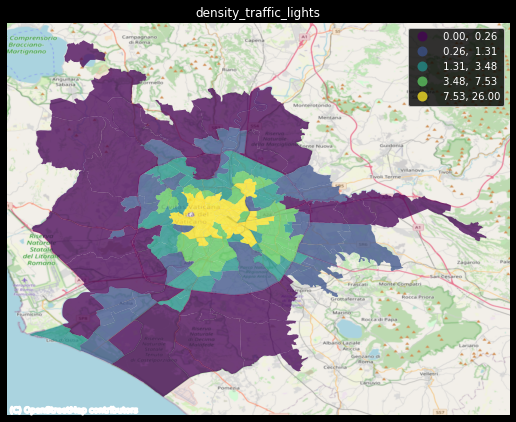

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rome.plot(column=feature, 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 1},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=gdf_rome.crs, 
                       source=contextily.providers.OpenStreetMap.Mapnik
                      )
ax.set_title(f"{feature}")
ax.set_axis_off()

## Spatial weights

In [7]:
# TODO: choose the right weight
w = weights.Rook.from_dataframe(gdf_rome)
w.transform = 'R'

('WARNING: ', 97, ' is an island (no neighbors)')


In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])

In [9]:
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

In [10]:
feature_lag = f"{feature}_lag"
gdf_rome_connected[feature_lag] = weights.spatial_lag.lag_spatial(w, gdf_rome_connected[feature])

## Top differences

In [11]:
df_diff = (gdf_rome_connected[["area_name", feature, feature_lag]]
    .set_index("area_name")
    .join_apply(lambda row: row[feature] - row[feature_lag], new_column_name="diff")
    .sort_values(by="diff")
)

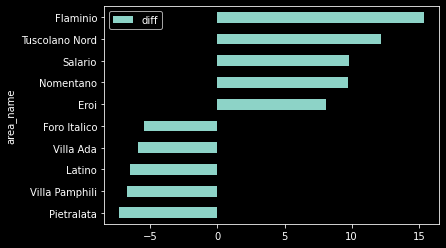

In [12]:
# TODO: This should be moved to Local Spatial Autocorrelation
_ = pd.concat([df_diff.head(5), df_diff.tail(5)]).plot.barh(y="diff")

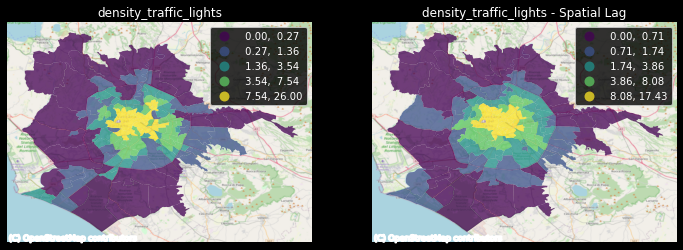

In [13]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

gdf_rome_connected.plot(column=feature, cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title(f"{feature}")
contextily.add_basemap(ax1, 
                       crs=gdf_rome_connected.crs, 
                       source=contextily.providers.OpenStreetMap.Mapnik,
                       
                      )

gdf_rome_connected.plot(column=feature_lag, cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title(f"{feature} - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=gdf_rome_connected.crs, 
                       source=contextily.providers.OpenStreetMap.Mapnik,
                       
                      )

plt.show()

## Moran I

In [14]:
moran = esda.moran.Moran(gdf_rome_connected[feature], w)

In [15]:
moran.I, moran.p_sim

(0.6669257261928274, 0.001)

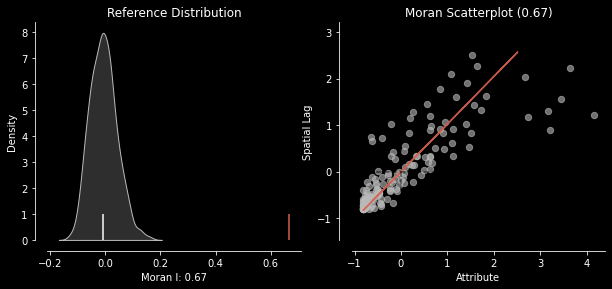

In [16]:
_ = plot_moran(moran, zstandard=True, aspect_equal=True)

# Watermark

In [17]:
%load_ext watermark
%watermark

Last updated: 2022-02-27T21:45:59.407841+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.4.0-210-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [18]:
%watermark --iversions

libpysal  : 4.6.0
matplotlib: 3.5.1
pandas    : 1.4.1
geopandas : 0.10.2
janitor   : 0.22.0
sys       : 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:42:07) 
[GCC 9.4.0]
esda      : 2.4.1
contextily: 1.2.0

